In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tabulate import tabulate

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from xgboost import XGBClassifier

# Test 1: With Enrolled and Approved

## Import file

In [2]:
User = "Kai Jie\Jupyter_DS\Assignment\Final"
file_name = "filtered_test_1"
file_path = rf"C:\Users\{User}\{file_name}.csv"
df = pd.read_csv(file_path)

In [3]:
df.shape

(2274, 28)

In [4]:
df['Target'].unique()

array([1, 0, 2], dtype=int64)

In [5]:
drop_list = [2]
df = df[~df['Target'].isin(drop_list)]

In [6]:
df['Target'].unique()

array([1, 0], dtype=int64)

## Data sampling

In [7]:
percentage_to_extract = 0.05

# Separate data based on target values
df_target_0 = df[df['Target'] == 0]
df_target_1 = df[df['Target'] == 1]

# Calculate the number of samples to extract for each target value
num_samples_each_target = int(len(df) * percentage_to_extract / 2)

# Randomly sample data for each target value
sampled_data_target_0 = df_target_0.sample(n=num_samples_each_target)
sampled_data_target_1 = df_target_1.sample(n=num_samples_each_target)

df_unseen = pd.concat([sampled_data_target_0, sampled_data_target_1])

# Remove the unseen data from the original dataframe to get the training data
df = df.drop(df_unseen.index)

# Shuffle the new dataframes
df_unseen = df_unseen.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

X_unseen = df_unseen.drop('Target', axis=1)
Y_unseen_true = df_unseen['Target']

In [8]:
df.shape

(1722, 28)

## Train, test, validation(unseen)

In [9]:
target = df['Target']
features = df.drop(columns=['Target'])

X_train, X_temp, Y_train, Y_temp = train_test_split(features,target, test_size=0.4, random_state=123, shuffle=True)

#X_temp & Y_temp bring into here to split into test and validation
X_val, X_test, Y_val, Y_test = train_test_split(X_temp,Y_temp, test_size=0.2, random_state=123, shuffle=True)

# Print class distribution before resampling
print("Class distribution before resampling:")
print("Y_train distribution:\n", Y_train.value_counts())
print("Y_temp distribution:\n", Y_temp.value_counts())

# Print class distribution of validation and test sets
print("\nClass distribution of validation and test sets:")
print("Y_val distribution:\n", Y_val.value_counts())
print("Y_test distribution:\n", Y_test.value_counts())

Class distribution before resampling:
Y_train distribution:
 Target
1    860
0    173
Name: count, dtype: int64
Y_temp distribution:
 Target
1    572
0    117
Name: count, dtype: int64

Class distribution of validation and test sets:
Y_val distribution:
 Target
1    457
0     94
Name: count, dtype: int64
Y_test distribution:
 Target
1    115
0     23
Name: count, dtype: int64


## Data Resampling

In [10]:
# Check the class distribution before resampling
print("Class Distribution Before Resampling:")
print(Counter(Y_train))

Class Distribution Before Resampling:
Counter({1: 860, 0: 173})


In [11]:
rus = RandomUnderSampler(random_state=123)
X_train_resampled, Y_train_resampled = rus.fit_resample(X_train, Y_train)

# Check the class distribution after resampling
print("Class Distribution After Resampling:")
print(Counter(Y_train_resampled))

Class Distribution After Resampling:
Counter({0: 173, 1: 173})


## StandardScaler

In [12]:
sc = StandardScaler()

# Fit the scaler on training data and transform training data
X_train_resampled = sc.fit_transform(X_train_resampled)

# Transform test and validation data using the same scaler
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

print("\nTraining Set Shape:", X_train_resampled.shape, Y_train_resampled.shape)
print("Test Set Shape:", X_test.shape, Y_test.shape)
print("Unseen Data Shape:", X_val.shape, Y_val.shape)


Training Set Shape: (346, 27) (346,)
Test Set Shape: (138, 27) (138,)
Unseen Data Shape: (551, 27) (551,)


## Functions

In [13]:
def evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    predictions = model.predict(X_val)

    # Calculate and print evaluation metrics
    accuracy = round(accuracy_score(Y_val, predictions), 4)
    precision = round(precision_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    recall = round(recall_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    f1 = round(f1_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    error_rate = round(1 - accuracy, 4)

    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Support': f1,
        'Error Rate': error_rate
    }
    return results
    


def evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    Y_test_pred = model.predict(X_test)

    # Calculate and print evaluation metrics
    accuracy = round(accuracy_score(Y_test, Y_test_pred), 4)
    precision = round(precision_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    recall = round(recall_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    f1 = round(f1_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    error_rate = round(1 - accuracy, 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Support': f1,
        'Error Rate': error_rate
    }
    return results


def evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    Y_train_pred = model.predict(X_train_resampled)

    # Calculate and print evaluation metrics
    train_acc = round(accuracy_score(Y_train_resampled, Y_train_pred), 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': train_acc
    }
    return results



def default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test):
    model_default = insert_model
    
    # Fit the model on the training data
    model_default.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on training data
    Y_train_pred_default = model_default.predict(X_train_resampled)
    
    # Predict on validation set
    Y_val_pred_default = model_default.predict(X_val)
    
    # Predict on test set
    Y_test_pred_default = model_default.predict(X_test)
    
    # Calculate and print accuracy for the default model
    train_accuracy_default = round(accuracy_score(Y_train_resampled, Y_train_pred_default), 4)
    test_accuracy_default = round(accuracy_score(Y_test, Y_test_pred_default), 4)
    val_accuracy_default = round(accuracy_score(Y_val, Y_val_pred_default), 4)

    # Calculate error rate
    train_accuracy_error_rate = round(1 - train_accuracy_default , 4)
    test_accuracy_error_rate = round(1 - test_accuracy_default , 4)
    val_accuracy_error_rate = round(1 - val_accuracy_default , 4)

    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Train Accuracy': train_accuracy_default,
        'Test Accuracy': test_accuracy_default,
        'Valid Accuracy': val_accuracy_default,
        'Train ACC Error': train_accuracy_error_rate,
        'Test ACC Error': test_accuracy_error_rate,
        'Valid ACC Error': val_accuracy_error_rate,
    }
    return results



def default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test):
    model_default = insert_model
    
    # Fit the model on the training data
    model_default.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on training data
    Y_train_pred_default = model_default.predict(X_train_resampled)
    
    # Predict on validation set
    Y_val_pred_default = model_default.predict(X_val)
    
    # Predict on test set
    Y_test_pred_default = model_default.predict(X_test)

    # Calculate classification reports
    train_classification_report = classification_report(Y_train_resampled, Y_train_pred_default, output_dict=True)
    test_classification_report = classification_report(Y_test, Y_test_pred_default, output_dict=True)
    val_classification_report = classification_report(Y_val, Y_val_pred_default, output_dict=True)

    # Calculate confusion matrices
    train_confusion_matrix = confusion_matrix(Y_train_resampled, Y_train_pred_default)
    test_confusion_matrix = confusion_matrix(Y_test, Y_test_pred_default)
    val_confusion_matrix = confusion_matrix(Y_val, Y_val_pred_default)

    # Display classification report
    print(f"Classification Report for Training Data:\n{classification_report(Y_train_resampled, Y_train_pred_default)}")
    print(f"Classification Report for Test Data:\n{classification_report(Y_test, Y_test_pred_default)}")
    print(f"Classification Report for Validation Data:\n{classification_report(Y_val, Y_val_pred_default)}")

    # Display confusion matrix
    def plot_confusion_matrix(cm, title='Confusion Matrix'):
        plt.figure(figsize=(3,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_default.classes_, yticklabels=model_default.classes_)
        plt.title(title)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    print("Confusion Matrix for Training Data:")
    plot_confusion_matrix(train_confusion_matrix, title='Confusion Matrix for Training Data')

    print("Confusion Matrix for Test Data:")
    plot_confusion_matrix(test_confusion_matrix, title='Confusion Matrix for Test Data')
    
    print("Confusion Matrix for Validation Data:")
    plot_confusion_matrix(val_confusion_matrix, title='Confusion Matrix for Validation Data')



def cross_validate_default_model(model, model_name, cv, X_train_resampled, Y_train_resampled):
    cross_val_scores = cross_val_score(model, X_train_resampled, Y_train_resampled, cv=cv, scoring='accuracy')
    mean_cv_score = round(np.mean(cross_val_scores), 4)
    std_cv_score = round(np.std(cross_val_scores), 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'CV score': ', '.join([f'{score:.4f}' for score in cross_val_scores]),
        'Mean CV': mean_cv_score,
        'Std CV': std_cv_score,
    }
    return results

In [14]:
valid_list = []
test_list = []
train_list = []
acc_train_test_valid_list = []
hyper_list = []

def showTablulate(txt, results_list, number):
    if number == 0:
        headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Support', 'Error Rate']
    elif number == 1:
        headers = ['Model', 'Accuracy']
    elif number == 2:
        headers = ['Model', 'Train Accuracy', 'Test Accuracy', 'Valid Accuracy', 'Train ACC Error', 'Test ACC Error', 'Valid ACC Error']
    elif number == 3:
        headers = ['Model', 'Best HP.', 'Train Accuracy', 'Test Accuracy', 'Valid Accuracy', 'Precision Unseen %', 'Accuracy Unseen %']
    elif number == 4:
        headers = ['Model', 'CV score', 'Mean CV', 'Std CV']

    # Convert list of dictionaries to list of lists
    table_data = []
    for result in results_list:
        row = [result.get(header, 'N/A') for header in headers]  # Use 'N/A' for missing data
        table_data.append(row)

    # Use tabulate to format the results into a table
    table = tabulate(table_data, headers=headers, tablefmt='grid')

    # Print the table
    print(f"{txt}")
    print(table)
    print("\n")

In [15]:
def hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average):
    model_grid_search = insert_model_hyperparameter

    # Fit GridSearchCV on the training data
    model_grid_search.fit(X_train_resampled, Y_train_resampled)

    # Predict on training data using the best model from Grid Search
    Y_train_pred_grid = model_grid_search.predict(X_train_resampled)
    
    # Extract the best hyperparameters
    best_params = model_grid_search.best_params_
    best_model = model_grid_search.best_estimator_
    best_score = round(model_grid_search.best_score_ , 4)
    print(f'Best Hyperparameters for {model_name}: {best_params}')
    print(f'Best cross-validation for {model_name}: {best_score}')
    
    # Predict using the best model
    Y_val_pred_grid = best_model.predict(X_val)
    Y_test_pred_grid = best_model.predict(X_test)

    # Calculate and print accuracy for the Grid Search model
    train_accuracy_grid = round(accuracy_score(Y_train_resampled, Y_train_pred_grid), 4)
    test_accuracy_grid = round(accuracy_score(Y_test, Y_test_pred_grid), 4)
    val_accuracy_grid = round(accuracy_score(Y_val, Y_val_pred_grid), 4)

    print(f'Train Accuracy: {train_accuracy_grid}')
    print(f'Test Accuracy: {test_accuracy_grid}')
    print(f'Valid Accuracy: {val_accuracy_grid}')

    Y_unseen_pred = model_grid_search.predict(X_unseen)

    # Evaluate the model on the unseen data
    precision_unseen = precision_score(Y_unseen_true, Y_unseen_pred, average=average, zero_division=1) * 100   # Use appropriate average method for binary/multi-class
    accuracy_unseen = accuracy_score(Y_unseen_true, Y_unseen_pred) * 100
    
    # Format the results as percentages with 2 decimal places
    precision_unseen_formatted = round(precision_unseen, 2)
    accuracy_unseen_formatted = round(accuracy_unseen, 2)

    print(f'Precision Unseen %: {precision_unseen_formatted}')
    print(f'Accuracy Unseen %: {accuracy_unseen_formatted}')

    # Display relevant columns from DataFrame
    cv_results = pd.DataFrame(model_grid_search.cv_results_)
    
    # Identify parameter columns dynamically
    param_columns = [col for col in cv_results.columns if col.startswith('param_')]
    sorted_cv_results = cv_results.sort_values(by='rank_test_score')
    
    print(f"\n{sorted_cv_results[['rank_test_score', 'mean_test_score', 'std_test_score'] + param_columns]}")

    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Best HP.': '\n'.join([f'{param}: {value}' for param, value in best_params.items()]),
        'Best CV score.': best_score,
        'Train Accuracy': train_accuracy_grid,
        'Test Accuracy': test_accuracy_grid,
        'Valid Accuracy': val_accuracy_grid,
        'Precision Unseen %': precision_unseen_formatted,
        'Accuracy Unseen %': accuracy_unseen_formatted,
    }
    return results

# Models

## SVM

### Default SVM

In [16]:
insert_model = SVC(random_state=123)
model_name = "SVM"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'SVM',
 'Train Accuracy': 0.896,
 'Test Accuracy': 0.8551,
 'Valid Accuracy': 0.8385,
 'Train ACC Error': 0.104,
 'Test ACC Error': 0.1449,
 'Valid ACC Error': 0.1615}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       173
           1       0.85      0.96      0.90       173

    accuracy                           0.90       346
   macro avg       0.90      0.90      0.90       346
weighted avg       0.90      0.90      0.90       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        23
           1       0.91      0.91      0.91       115

    accuracy                           0.86       138
   macro avg       0.74      0.74      0.74       138
weighted avg       0.86      0.86      0.86       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.52      0.70      0.60        94
           1       0.93      0.87      0.90       457

    accuracy                           0.84       551
   macr

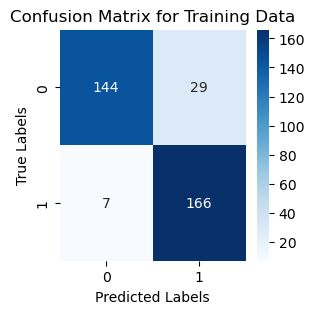

Confusion Matrix for Test Data:


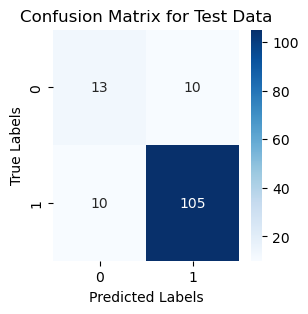

Confusion Matrix for Validation Data:


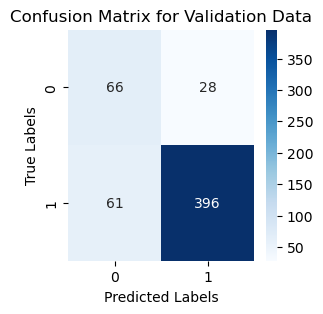

In [17]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid SVM

In [18]:
model = SVC(random_state=123)

param_grid_svm = {
    'C' : [0.1, 1, 10,100],
    'kernel' : ['linear','rbf','poly','sigmoid'],
    'degree' : [2,3,4], # Relevant only for 'poly' kernel
    'gamma' : ['scale','auto'],
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_svm,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "macro"
model_name = "Param_grid_SVM"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best Hyperparameters for Param_grid_SVM: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation for Param_grid_SVM: 0.7977
Train Accuracy: 0.896
Test Accuracy: 0.8551
Valid Accuracy: 0.8385
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

    rank_test_score  mean_test_score  std_test_score param_C param_degree  \
29                1         0.797748        0.032936       1            2   
45                1         0.797748        0.032936       1            4   
37                1         0.797748        0.032936       1            3   
33                4         0.794841        0.028515       1            3   
41                4         0.794841        0.028515       1            4   
..              ...              ...             ...     ...          ...   
42               92         0.583835        0.013417       1            4   
2                93         0.549151        0.013368     0.

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


## Decision Tree (DT)

### Default DT

In [19]:
insert_model = DecisionTreeClassifier(random_state=123)
model_name = "DT"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'DT',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.7536,
 'Valid Accuracy': 0.7368,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.2464,
 'Valid ACC Error': 0.2632}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.36      0.61      0.45        23
           1       0.91      0.78      0.84       115

    accuracy                           0.75       138
   macro avg       0.63      0.70      0.65       138
weighted avg       0.82      0.75      0.78       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.36      0.71      0.48        94
           1       0.93      0.74      0.82       457

    accuracy                           0.74       551
   macr

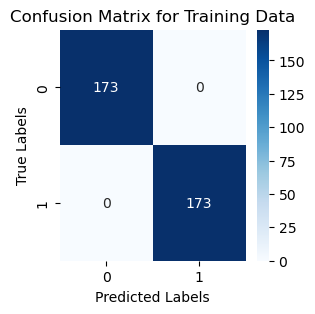

Confusion Matrix for Test Data:


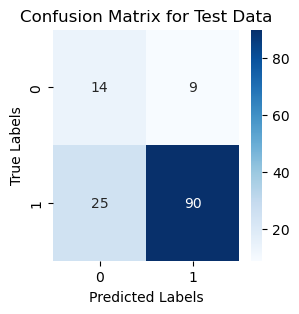

Confusion Matrix for Validation Data:


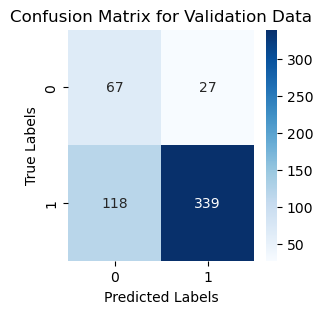

In [20]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid DT

In [21]:
model = DecisionTreeClassifier(random_state=123, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=4
)

param_grid_dt = {
    'criterion': ['gini', 'entropy'],             # Quality measure of a split
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]                   # Minimum samples required at a leaf node
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_dt,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_DT"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best Hyperparameters for Param_grid_DT: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation for Param_grid_DT: 0.7602
Train Accuracy: 0.922
Test Accuracy: 0.7536
Valid Accuracy: 0.7441
Precision Unseen %: 28.4
Accuracy Unseen %: 42.22

     rank_test_score  mean_test_score  std_test_score param_criterion  \
65                 1         0.760158        0.039339         entropy   
71                 2         0.754511        0.049010         entropy   
68                 3         0.754377        0.038409         entropy   
56                 4         0.754344        0.031992         entropy   
101                4         0.754344        0.031992         entropy   
..               ...              ...             ...             ...   
27               104         0.682104        0.036898            gini   
36               104         0.682104        0.036898    

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## Random Forest (RF)

### Default RF

In [22]:
insert_model = RandomForestClassifier(random_state=123)
model_name = "RF"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'RF',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.8623,
 'Valid Accuracy': 0.8584,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.1377,
 'Valid ACC Error': 0.1416}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.93      0.90      0.92       115

    accuracy                           0.86       138
   macro avg       0.75      0.78      0.76       138
weighted avg       0.87      0.86      0.87       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.56      0.77      0.65        94
           1       0.95      0.88      0.91       457

    accuracy                           0.86       551
   macr

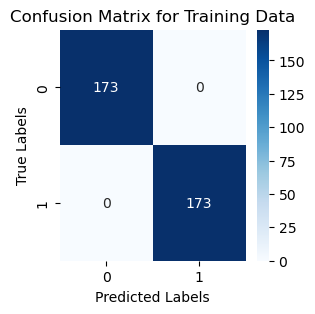

Confusion Matrix for Test Data:


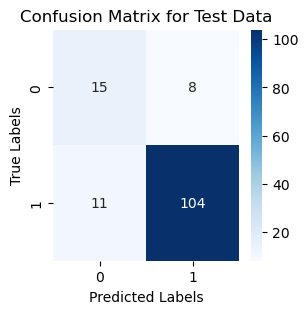

Confusion Matrix for Validation Data:


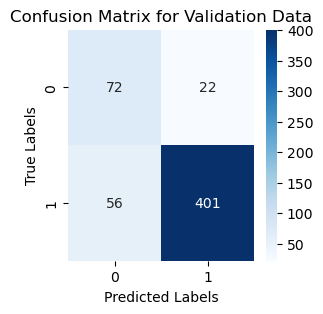

In [23]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid RF

In [24]:
model = RandomForestClassifier(
    random_state=123, 
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=4, 
    max_features='sqrt'
)

param_grid_rf = {
    'n_estimators' : [10,50,100,200],
    'criterion' : ['gini','entropy'],
    'max_depth' : [None, 1, 5, 10, 15, 20],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_rf,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_RF"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
Best Hyperparameters for Param_grid_RF: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation for Param_grid_RF: 0.8095
Train Accuracy: 0.9711
Test Accuracy: 0.8478
Valid Accuracy: 0.8566
Precision Unseen %: 61.62
Accuracy Unseen %: 53.33

     rank_test_score  mean_test_score  std_test_score param_criterion  \
115                1         0.809476        0.046302            gini   
331                2         0.806636        0.054008         entropy   
187                3         0.806569        0.044049            gini   
151                3         0.806569        0.044049            gini   
7                  3         0.806569        0.044049            gini   
..               ...              ...             ...             ...   
124              428         0.760124        0.034804            gini   
332              429         0.757318

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Gradient Boosting (GB)

### Default GB

In [25]:
insert_model = GradientBoostingClassifier(random_state=123)
model_name = "GB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'GB',
 'Train Accuracy': 0.9798,
 'Test Accuracy': 0.7754,
 'Valid Accuracy': 0.8276,
 'Train ACC Error': 0.0202,
 'Test ACC Error': 0.2246,
 'Valid ACC Error': 0.1724}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       173
           1       0.96      1.00      0.98       173

    accuracy                           0.98       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.98      0.98      0.98       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.38      0.57      0.46        23
           1       0.90      0.82      0.86       115

    accuracy                           0.78       138
   macro avg       0.64      0.69      0.66       138
weighted avg       0.82      0.78      0.79       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.50      0.68      0.57        94
           1       0.93      0.86      0.89       457

    accuracy                           0.83       551
   macr

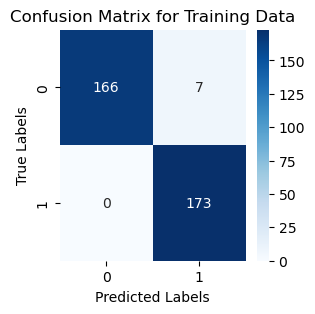

Confusion Matrix for Test Data:


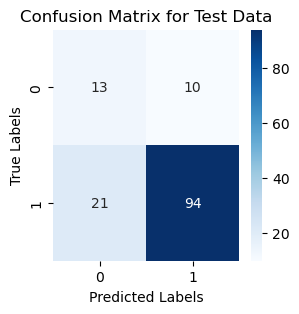

Confusion Matrix for Validation Data:


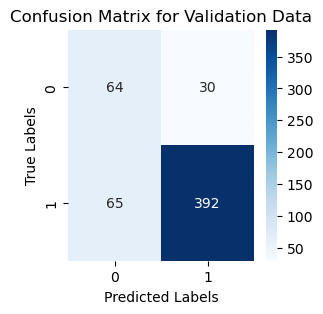

In [26]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid GB

In [27]:
model = GradientBoostingClassifier(
    random_state=123, 
    n_estimators=50, 
    learning_rate=0.1, 
    max_depth=3, 
    subsample=0.8
)

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_gb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_GB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best Hyperparameters for Param_grid_GB: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.9}
Best cross-validation for Param_grid_GB: 0.8008
Train Accuracy: 0.9509
Test Accuracy: 0.8333
Valid Accuracy: 0.8403
Precision Unseen %: 64.42
Accuracy Unseen %: 56.67

    rank_test_score  mean_test_score  std_test_score param_learning_rate  \
51                1         0.800755        0.052368                 0.1   
49                1         0.800755        0.051061                 0.1   
67                1         0.800755        0.052368                 0.1   
16                4         0.797882        0.062698                0.01   
34                5         0.797882        0.057215                0.01   
..              ...              ...             ...                 ...   
88               91         0.771719        0.055816                 0.1  

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


## XGBoost (XGB)

### Default XGB

In [28]:
insert_model = XGBClassifier(random_state=123)
model_name = "XGB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'XGB',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.8043,
 'Valid Accuracy': 0.8385,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.1957,
 'Valid ACC Error': 0.1615}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.43      0.57      0.49        23
           1       0.91      0.85      0.88       115

    accuracy                           0.80       138
   macro avg       0.67      0.71      0.68       138
weighted avg       0.83      0.80      0.81       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.52      0.69      0.59        94
           1       0.93      0.87      0.90       457

    accuracy                           0.84       551
   macr

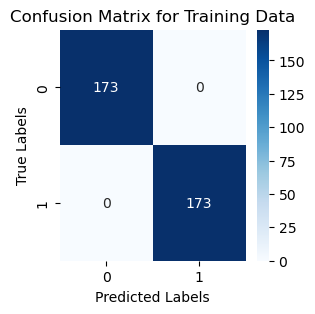

Confusion Matrix for Test Data:


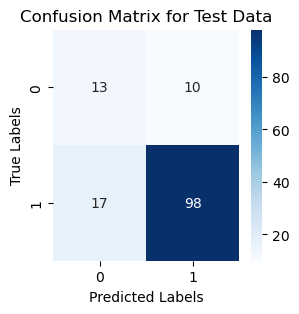

Confusion Matrix for Validation Data:


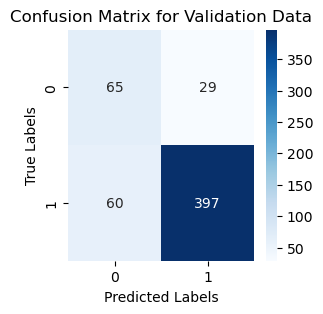

In [29]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid XGB

In [30]:
model = XGBClassifier(random_state=123)

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_xgb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_XGB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 243 candidates, totalling 972 fits
Best Hyperparameters for Param_grid_XGB: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation for Param_grid_XGB: 0.8065
Train Accuracy: 0.9624
Test Accuracy: 0.8261
Valid Accuracy: 0.8457
Precision Unseen %: 76.79
Accuracy Unseen %: 56.67

     rank_test_score  mean_test_score  std_test_score param_gamma  \
193                1         0.806502        0.047833         0.2   
15                 2         0.806435        0.042966           0   
118                3         0.803696        0.048711         0.1   
168                4         0.803629        0.052784         0.2   
87                 4         0.803629        0.052784         0.1   
..               ...              ...             ...         ...   
59               238         0.760158        0.033656           0   
150              240         0.757318        0.040108         0.1   
233           

## Naive Bayes (NB)

### Default NB

In [31]:
insert_model = GaussianNB()
model_name = "NB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'NB',
 'Train Accuracy': 0.7919,
 'Test Accuracy': 0.8406,
 'Valid Accuracy': 0.8512,
 'Train ACC Error': 0.2081,
 'Test ACC Error': 0.1594,
 'Valid ACC Error': 0.1488}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       173
           1       0.75      0.88      0.81       173

    accuracy                           0.79       346
   macro avg       0.80      0.79      0.79       346
weighted avg       0.80      0.79      0.79       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.52      0.48      0.50        23
           1       0.90      0.91      0.91       115

    accuracy                           0.84       138
   macro avg       0.71      0.70      0.70       138
weighted avg       0.84      0.84      0.84       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60        94
           1       0.93      0.89      0.91       457

    accuracy                           0.85       551
   macr

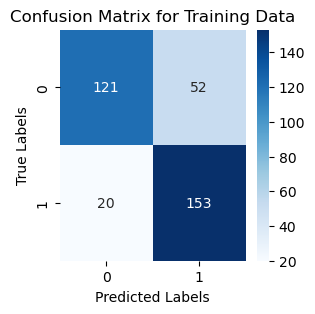

Confusion Matrix for Test Data:


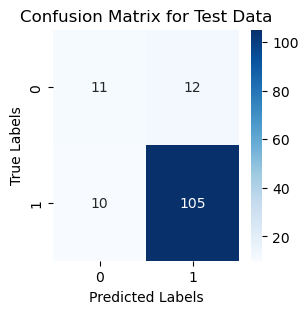

Confusion Matrix for Validation Data:


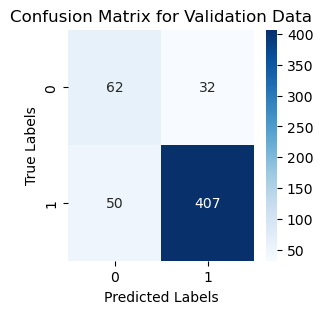

In [32]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid NB

In [33]:
model = GaussianNB(var_smoothing=1e-9)

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_nb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_NB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Hyperparameters for Param_grid_NB: {'var_smoothing': 1e-05}
Best cross-validation for Param_grid_NB: 0.7631
Train Accuracy: 0.7919
Test Accuracy: 0.8406
Valid Accuracy: 0.8512
Precision Unseen %: 63.5
Accuracy Unseen %: 63.33

   rank_test_score  mean_test_score  std_test_score param_var_smoothing
4                1         0.763065        0.032873             0.00001
3                2         0.754411        0.040796            0.000001
2                3         0.745790        0.051063                 0.0
1                4         0.737136        0.060169                 0.0
0                5         0.728482        0.069392                 0.0


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


## K-Nearest Neighbors (KNN)

### Default KNN

In [34]:
insert_model = KNeighborsClassifier()
model_name = "KNN"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'KNN',
 'Train Accuracy': 0.8208,
 'Test Accuracy': 0.8261,
 'Valid Accuracy': 0.8439,
 'Train ACC Error': 0.1792,
 'Test ACC Error': 0.1739,
 'Valid ACC Error': 0.1561}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81       173
           1       0.78      0.90      0.83       173

    accuracy                           0.82       346
   macro avg       0.83      0.82      0.82       346
weighted avg       0.83      0.82      0.82       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        23
           1       0.90      0.90      0.90       115

    accuracy                           0.83       138
   macro avg       0.69      0.69      0.69       138
weighted avg       0.83      0.83      0.83       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.54      0.62      0.57        94
           1       0.92      0.89      0.90       457

    accuracy                           0.84       551
   macr

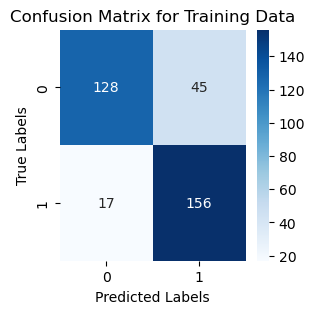

Confusion Matrix for Test Data:


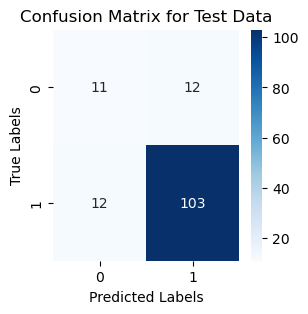

Confusion Matrix for Validation Data:


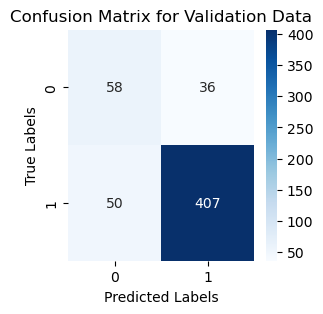

In [35]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid KNN

In [36]:
model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_knn,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_KNN"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best Hyperparameters for Param_grid_KNN: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best cross-validation for Param_grid_KNN: 0.7948
Train Accuracy: 1.0
Test Accuracy: 0.8261
Valid Accuracy: 0.8693
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

    rank_test_score  mean_test_score  std_test_score param_n_neighbors  \
13                1         0.794808        0.016854                10   
12                2         0.789094        0.019782                10   
15                3         0.765972        0.031317                10   
8                 4         0.765938        0.035533                 7   
9                 5         0.763031        0.036699                 7   
0                 6         0.760158        0.038188                 3   
11                7         0.754477        0.058850                 7   
10                8         0.754444        0.053704                 7   
5                

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## Logistic Regression (LR)

### Default LR

In [37]:
insert_model = LogisticRegression(random_state=123)
model_name = "LR"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'LR',
 'Train Accuracy': 0.8439,
 'Test Accuracy': 0.8551,
 'Valid Accuracy': 0.8494,
 'Train ACC Error': 0.1561,
 'Test ACC Error': 0.1449,
 'Valid ACC Error': 0.1506}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.88      0.79      0.84       173
           1       0.81      0.90      0.85       173

    accuracy                           0.84       346
   macro avg       0.85      0.84      0.84       346
weighted avg       0.85      0.84      0.84       346

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        23
           1       0.94      0.89      0.91       115

    accuracy                           0.86       138
   macro avg       0.74      0.79      0.76       138
weighted avg       0.87      0.86      0.86       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.55      0.70      0.61        94
           1       0.93      0.88      0.91       457

    accuracy                           0.85       551
   macr

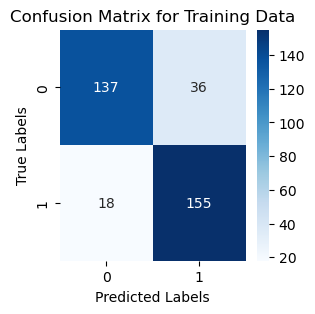

Confusion Matrix for Test Data:


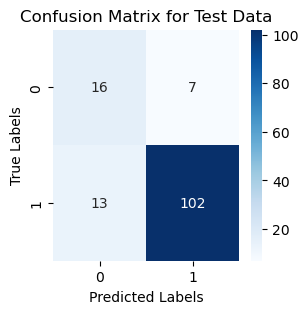

Confusion Matrix for Validation Data:


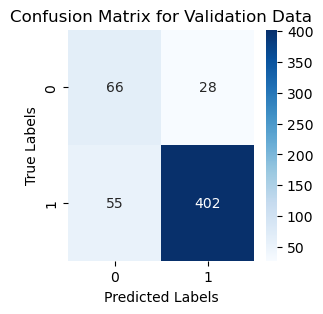

In [38]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid LR

In [39]:
model = LogisticRegression(random_state=123)
    
def get_param_grid_lr(solver):
    if solver == 'liblinear':
        return {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': [solver],
            'penalty': ['l1', 'l2']
        }
    elif solver == 'lbfgs':
        return {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': [solver],
            'penalty': ['l2']
        }
    else:
        raise ValueError("Unsupported solver")

param_grid_lib = get_param_grid_lr('liblinear')

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_lib,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)
average = "weighted"
model_name = "Param_grid_LR(lib)"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters for Param_grid_LR(lib): {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation for Param_grid_LR(lib): 0.792
Train Accuracy: 0.8237
Test Accuracy: 0.8333
Valid Accuracy: 0.8294
Precision Unseen %: 79.61
Accuracy Unseen %: 65.56

   rank_test_score  mean_test_score  std_test_score param_C param_penalty  \
2                1         0.792034        0.028501     0.1            l1   
4                2         0.786187        0.030541       1            l1   
3                3         0.783313        0.028029     0.1            l2   
1                4         0.780373        0.007332    0.01            l2   
5                5         0.774693        0.027871       1            l2   
7                5         0.774693        0.025391      10            l2   
6                7         0.771819        0.028773      10            l1   
8                7         0.771819        0.027601    

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [40]:
param_grid_lbf = get_param_grid_lr('lbfgs')
insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_lbf,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)
model_name = "Param_grid_LR(lbfgs)"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Hyperparameters for Param_grid_LR(lbfgs): {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation for Param_grid_LR(lbfgs): 0.7804
Train Accuracy: 0.8006
Test Accuracy: 0.8188
Valid Accuracy: 0.8276
Precision Unseen %: 77.78
Accuracy Unseen %: 60.0

   rank_test_score  mean_test_score  std_test_score param_C param_penalty  \
0                1         0.780373        0.007332    0.01            l2   
1                2         0.774693        0.036086     0.1            l2   
3                2         0.774693        0.025391      10            l2   
2                4         0.771819        0.032032       1            l2   
4                4         0.771819        0.027601     100            l2   

  param_solver  
0        lbfgs  
1        lbfgs  
3        lbfgs  
2        lbfgs  
4        lbfgs  


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Overall comparison between default models

    Accuracy: Overall correctness of the model. Higher is generally better.
    
    Precision: Proportion of true positives among predicted positives. Higher is better, especially if false positives are costly.
    
    F1-Score: Harmonic mean of precision and recall. Balances precision and recall. Higher is better.
    
    Error Rate: Proportion of incorrect predictions. Lower is better.
    
    Cross-Validation Mean Accuracy: Average accuracy across different data subsets. Higher is better.
    
    Cross-Validation Standard Deviation: Variability of accuracy across folds. Lower is better.

In [41]:
# Show results in a table
showTablulate("Valid resutlts of Default Models", valid_list, 0)
showTablulate("Test resutlts of Default Models", test_list, 0)
showTablulate("Train resutlts of Default Models", train_list, 1)
showTablulate("Train, test, validation accuracy resutlts of Default Models", acc_train_test_valid_list, 2)

Valid resutlts of Default Models
+---------+------------+-------------+----------+--------------+--------------+
| Model   |   Accuracy |   Precision |   Recall |   F1-Support |   Error Rate |
+=========+============+=============+==========+==============+==============+
| SVM     |     0.8551 |      0.8551 |   0.8551 |       0.8551 |       0.1449 |
+---------+------------+-------------+----------+--------------+--------------+
| DT      |     0.7536 |      0.8174 |   0.7536 |       0.7762 |       0.2464 |
+---------+------------+-------------+----------+--------------+--------------+
| RF      |     0.8623 |      0.87   |   0.8623 |       0.8656 |       0.1377 |
+---------+------------+-------------+----------+--------------+--------------+
| GB      |     0.7754 |      0.8169 |   0.7754 |       0.7914 |       0.2246 |
+---------+------------+-------------+----------+--------------+--------------+
| XGB     |     0.8043 |      0.8284 |   0.8043 |       0.8142 |       0.1957 |
+------

### Cross-Validation between default models

In [42]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
cv_list = []

SVM_default = SVC(random_state=123)
DT_default = DecisionTreeClassifier(random_state=123)
RF_default = RandomForestClassifier(random_state=123)
GB_default = GradientBoostingClassifier(random_state=123)
XGB_default = XGBClassifier(random_state=123)
NB_default = GaussianNB()
KNN_default = KNeighborsClassifier()
LR_default = LogisticRegression(random_state=123)

models = [SVM_default, DT_default, RF_default, GB_default, XGB_default, NB_default, KNN_default, LR_default]
model_names = ['SVC', 'DT', 'RF', 'GB', 'XGB', 'NB', 'KNN', 'LR']

for model, name in zip(models, model_names):
    cv_results = cross_validate_default_model(model, name, cv, X_train_resampled, Y_train_resampled)
    cv_list.append(cv_results)

showTablulate("Cross-validation resutlts of Default Models", cv_list, 4)

Cross-validation resutlts of Default Models
+---------+----------------------------------------+-----------+----------+
| Model   | CV score                               |   Mean CV |   Std CV |
+=========+========================================+===========+==========+
| SVC     | 0.7857, 0.7246, 0.8261, 0.8261, 0.7826 |    0.789  |   0.0373 |
+---------+----------------------------------------+-----------+----------+
| DT      | 0.6857, 0.6812, 0.7391, 0.6667, 0.6667 |    0.6879 |   0.0267 |
+---------+----------------------------------------+-----------+----------+
| RF      | 0.7714, 0.7536, 0.8406, 0.8116, 0.7826 |    0.792  |   0.0308 |
+---------+----------------------------------------+-----------+----------+
| GB      | 0.8000, 0.7391, 0.8406, 0.7681, 0.8261 |    0.7948 |   0.0372 |
+---------+----------------------------------------+-----------+----------+
| XGB     | 0.7429, 0.7391, 0.7826, 0.7391, 0.7536 |    0.7515 |   0.0164 |
+---------+---------------------------------

    High Mean CV Score: Ensures that the model is capable of achieving good accuracy.
    Low Std CV: Ensures that the model's performance is reliable and generalizes well across different datasets.
    
    Example
    Consider two models:
        Model A: Mean CV = 0.90, Std CV = 0.02
        Model B: Mean CV = 0.88, Std CV = 0.01
    
        Model A has a higher mean CV score but also a higher standard deviation, suggesting that while it performs better on average, it might be less consistent.
        Model B has a slightly lower mean CV score but with a lower standard deviation, indicating more consistent performance.

## Overall comparison between param_grid (Hypertunned) models

In [43]:
showTablulate("Hypertunning resutlts of Models", hyper_list, 3)

Hypertunning resutlts of Models
+----------------------+-----------------------+------------------+-----------------+------------------+----------------------+---------------------+
| Model                | Best HP.              |   Train Accuracy |   Test Accuracy |   Valid Accuracy |   Precision Unseen % |   Accuracy Unseen % |
+======================+=======================+==================+=================+==================+======================+=====================+
| Param_grid_SVM       | C: 1                  |           0.896  |          0.8551 |           0.8385 |                75    |               50    |
|                      | degree: 2             |                  |                 |                  |                      |                     |
|                      | gamma: auto           |                  |                 |                  |                      |                     |
|                      | kernel: rbf           |                  | 

# Neutral Network

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## function

In [45]:
def pickScaler(sc, X_train_resampled, X_val, X_test, X_unseen):
    # Check if the scaler is a StandardScaler
    if isinstance(sc, StandardScaler):
        X_train_resampled_scaled = X_train_resampled
        X_val_scaled = X_val
        X_test_scaled = X_test
        X_unseen_scaled = X_unseen
        scaler_name = "StandardScaler"
    else:
        scaler = sc
        X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        X_unseen_scaled = scaler.transform(X_unseen)

        # Determine the type of scaler used
        if isinstance(scaler, MinMaxScaler):
            scaler_name = "MinMaxScaler"
        elif isinstance(scaler, RobustScaler):
            scaler_name = "RobustScaler"

    return X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name


def build_wo_valid_model(scaler_name, epochs, batch_size, A, B, C, D):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(Y_train_resampled_categorical.shape[1], activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_resampled_scaled,
        Y_train_resampled_categorical,
        epochs=epochs,
        batch_size=batch_size,
    )

    # Evaluate the model on the training data
    train_loss, train_accuracy = model.evaluate(A, B, verbose=0)
    
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(C, D, verbose=0)
    
    # Round the metrics to 4 decimal places
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    
    # Prepare results
    results = {
        'Model': "Sequential()",
        'Scaler': scaler_name,
        'Train loss': train_loss,
        'Train accuracy': train_accuracy,
        'Test loss': test_loss,
        'Test accuracy': test_accuracy
    }
    return train_loss, train_accuracy, test_loss, test_accuracy, results, history



def build_valid_model(scaler_name, epochs, batch_size, X_val_scaled, Y_val_categorical, A, B, C, D):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(Y_train_resampled_categorical.shape[1], activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_resampled_scaled,
        Y_train_resampled_categorical,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_scaled, Y_val_categorical),
        verbose=-1
    )
    
    # Evaluate the model on the training and test data
    train_loss, train_accuracy = model.evaluate(A, B, verbose=0)
    test_loss, test_accuracy = model.evaluate(C, D, verbose=0)

    # Extract best validation accuracy from the history
    best_val_accuracy = max(history.history['val_accuracy'])
    
    # Round the metrics to 4 decimal places
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    best_val_accuracy = round(best_val_accuracy, 4)
    
    # Prepare results
    results = {
        'Model': "Sequential()",
        'Scaler': scaler_name,
        'Train loss': train_loss,
        'Train accuracy': train_accuracy,
        'Test loss': test_loss,
        'Test accuracy': test_accuracy,
        'Best Valid accuracy': best_val_accuracy
    }
    return train_loss, train_accuracy, test_loss, test_accuracy, results, history



def plot_wo_valid_loss_accuracy(history, input_1, input_2, loss, accuracy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[input_1], label=loss)
    plt.title(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history[input_2], label=accuracy)
    plt.title(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_valid_train(history, input_1, input_2, t_loss, v_loss, title_1, input_3, input_4, t_acc, v_acc, title_2):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(history.history[input_1], label=t_loss)
    plt.plot(history.history[input_2], label=v_loss)
    plt.title(title_1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history[input_3], label=t_acc)
    plt.plot(history.history[input_4], label=v_acc)
    plt.title(title_2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



wo_val_list = []
val_list = []

def showNNTablulate(txt, results_list, wo_valid=False):
    if wo_valid==True:
        headers = ['Model', 'Scaler', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy']
    else:
        headers = ['Model', 'Scaler', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy', 'Best Valid accuracy']
        
    # Convert list of dictionaries to list of lists
    table_data = []
    for result in results_list:
        row = [result.get(header, 'N/A') for header in headers]  # Use 'N/A' for missing data
        table_data.append(row)

    # Use tabulate to format the results into a table
    table = tabulate(table_data, headers=headers, tablefmt='grid')

    # Print the table
    print(f"{txt}")
    print(table)
    print('\n')

In [46]:
input_a = 'loss'
input_b = 'accuracy'
loss = 'Training loss'
accuracy = 'Training Accuracy'
input_2 = 'val_loss'
input_4 = 'val_accuracy'
v_loss = 'Test loss'
v_acc = 'Test accuracy'
title_1 = 'Training and Test Loss'
title_2 = 'Training and Test Accuracy'

## StandardScaler

### without validation data

In [47]:
# One-hot encode labels
Y_train_resampled_categorical = to_categorical(Y_train_resampled)
Y_val_categorical = to_categorical(Y_val)
Y_test_categorical = to_categorical(Y_test)

In [48]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(StandardScaler(), X_train_resampled, X_val, X_test, X_unseen)
epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

Epoch 1/50
11/11 [==============================] - 4s 4ms/step - loss: 0.6927 - accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5318
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.6127
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.6474
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6792
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6306 - accuracy: 0.7254
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.7803
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6097 - accuracy: 0.8150
Epoch 9/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.8150
Epoch 10/50
11/11 [==============================] - 0s 4ms/step - loss: 0.5882 - accuracy: 0.8266
Epoch 11/50
11/11 [

Train Accuracy: 0.9827, Train Loss: 0.1152
Test Accuracy: 0.8333, Test Loss: 0.5657


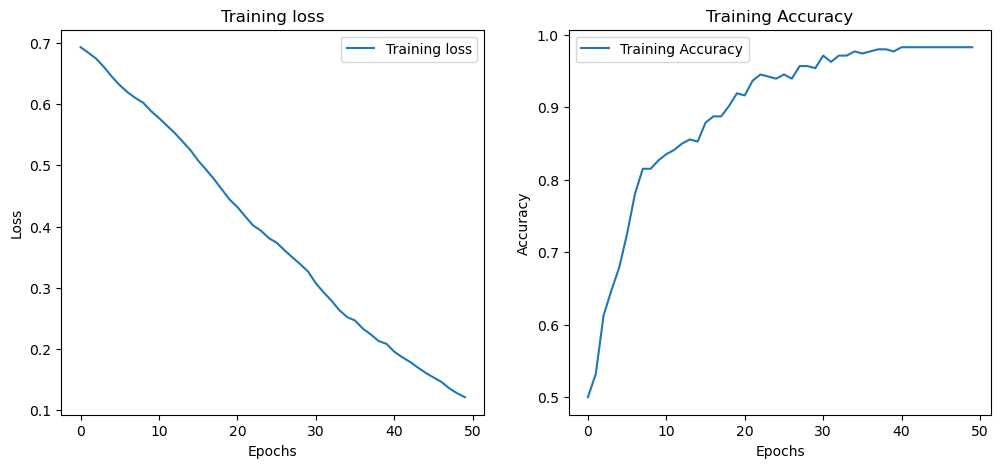

In [49]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [50]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.198, Training Accuracy: 0.9855
Test Loss: 0.3348, Test Accuracy: 0.8768


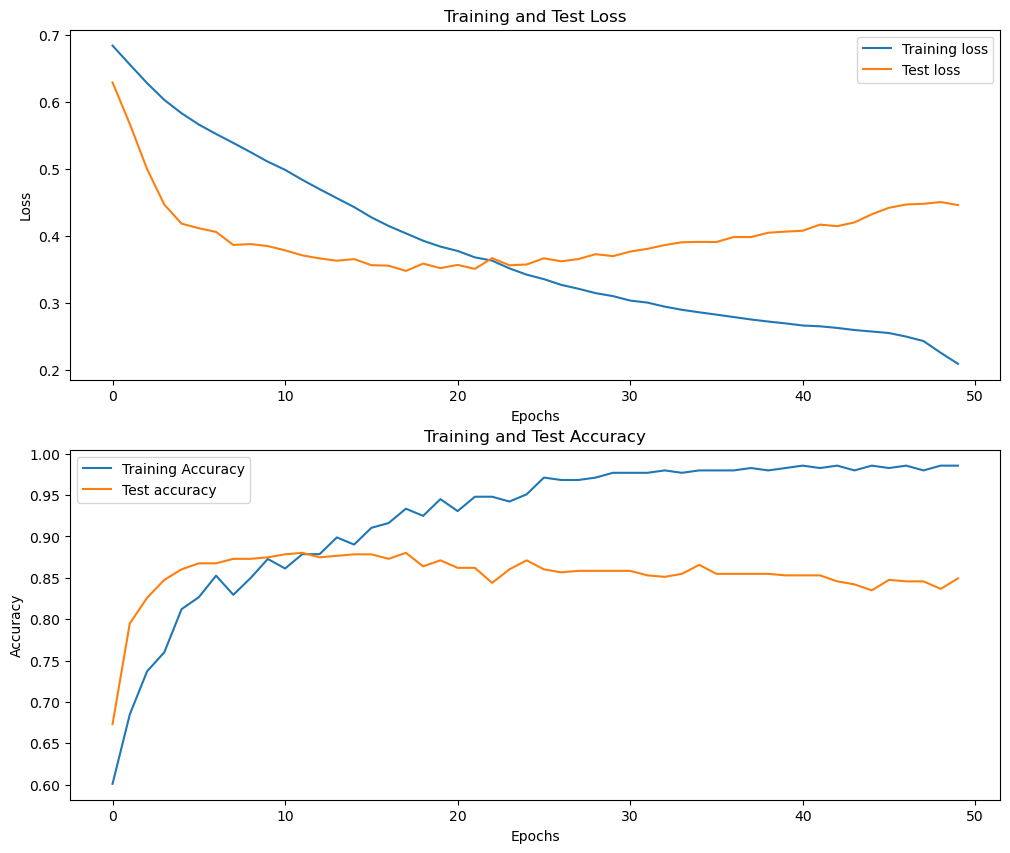

In [51]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## MinMaxScaler

### without validation data

In [52]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(MinMaxScaler(), X_train_resampled, X_val, X_test, X_unseen)

epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
11/11 [==============================] - 4s 3ms/step - loss: 0.6973 - accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5434
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.6879
Epoch 4/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.6936
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.7428
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.7486
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6655 - accuracy: 0.7890
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.7977
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6532 - accuracy: 0.8208
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6467 - accuracy: 0.8237
Epoch 11/50
11/11 [

Train Accuracy: 0.896, Train Loss: 0.3407
Test Accuracy: 0.8406, Test Loss: 1.1457


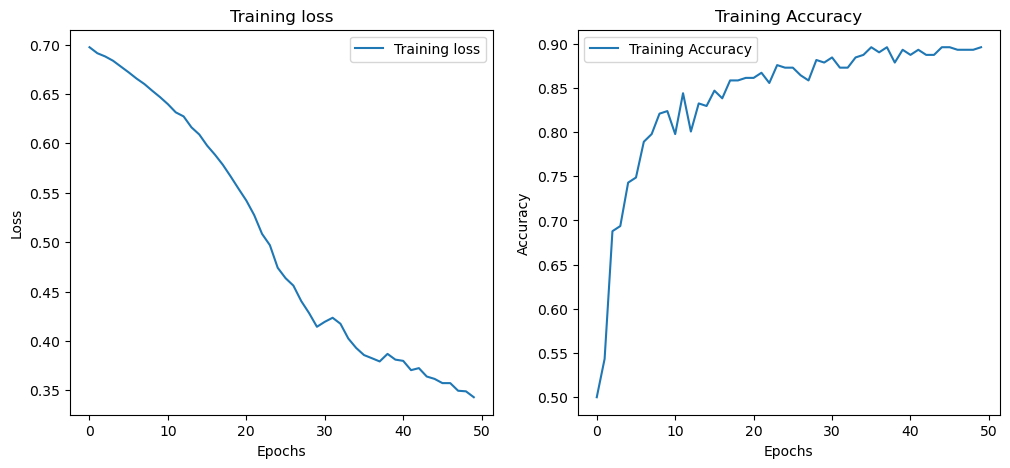

In [53]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [54]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.3598, Training Accuracy: 0.948
Test Loss: 0.3453, Test Accuracy: 0.8406


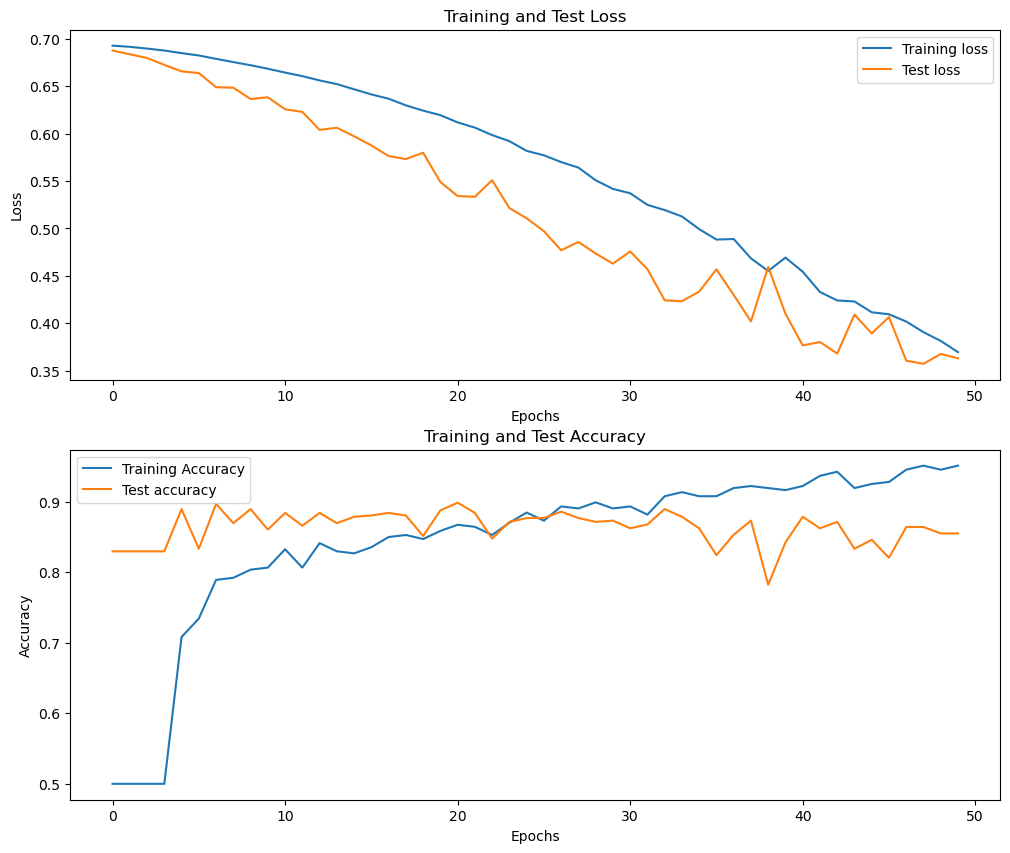

In [55]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## RobustScaler

### without validation data

In [56]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(RobustScaler(), X_train_resampled, X_val, X_test, X_unseen)

epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
11/11 [==============================] - 3s 10ms/step - loss: 0.6931 - accuracy: 0.4740
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 0.6860 - accuracy: 0.4971
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6632 - accuracy: 0.5029
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.6231 - accuracy: 0.7110
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.5882 - accuracy: 0.7428
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.5534 - accuracy: 0.7832
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 0.5211 - accuracy: 0.8064
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.4970 - accuracy: 0.8295
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.4795 - accuracy: 0.8555
Epoch 10/50
11/11 [==============================] - 0s 4ms/step - loss: 0.4627 - accuracy: 0.8555
Epoch 11/50
11/11 

Train Accuracy: 0.9306, Train Loss: 0.3028
Test Accuracy: 0.7971, Test Loss: 0.9846


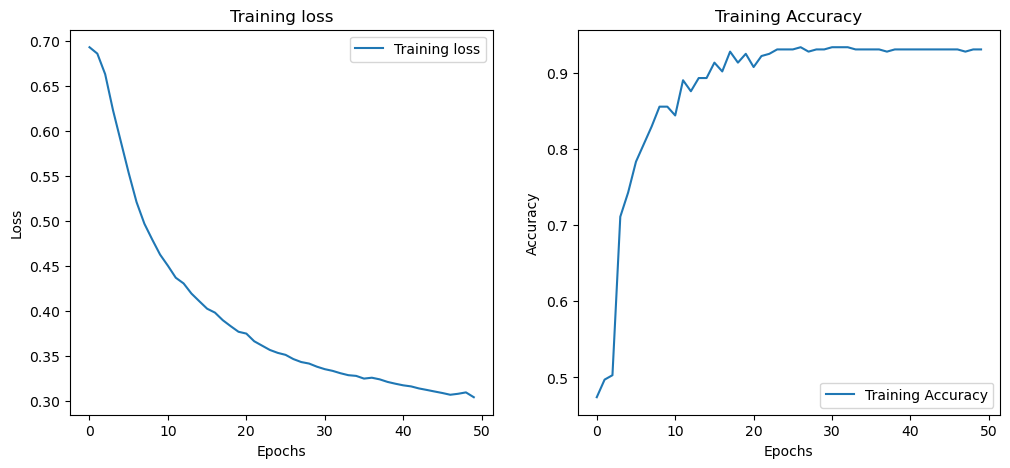

In [57]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [58]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.2975, Training Accuracy: 0.974
Test Loss: 0.3047, Test Accuracy: 0.8696


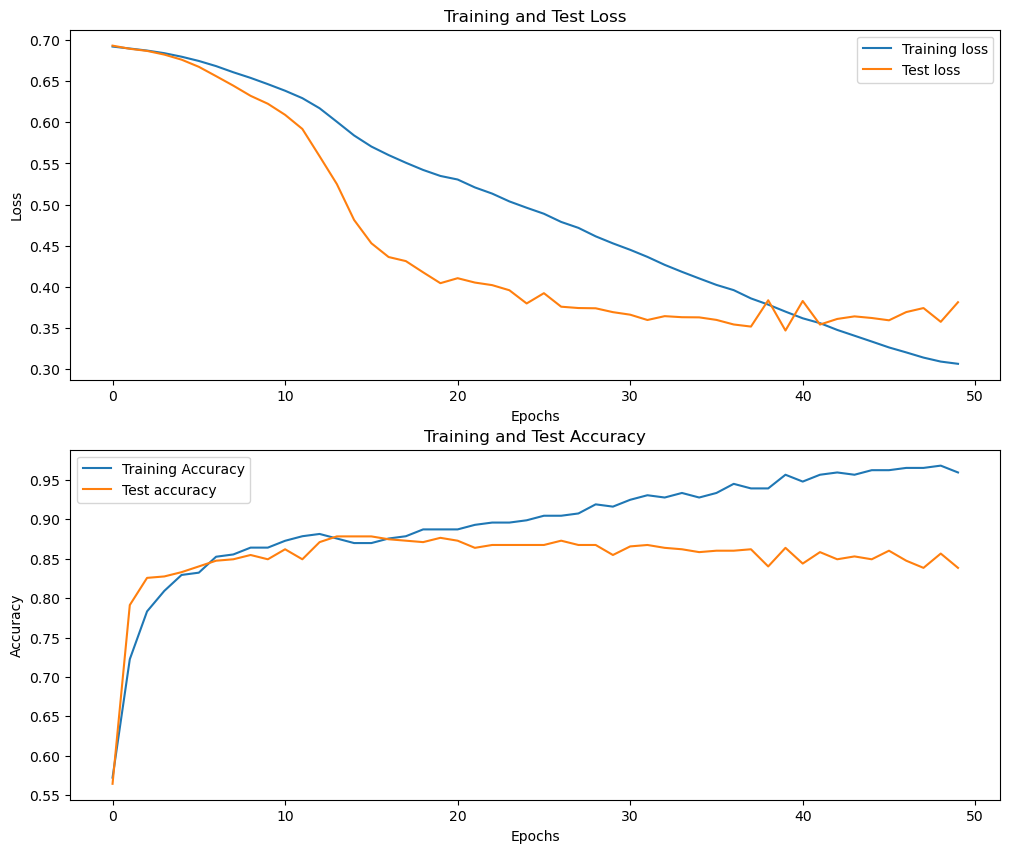

In [59]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## Overall comparison between different scalers on NN

In [60]:
showNNTablulate("Overall Without Validation Data", wo_val_list, True)
showNNTablulate("Overall With Validation Data", val_list, False)

Overall Without Validation Data
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Model        | Scaler         |   Train loss |   Train accuracy |   Test loss |   Test accuracy |
+==============+================+==============+==================+=============+=================+
| Sequential() | StandardScaler |       0.1152 |           0.9827 |      0.5657 |          0.8333 |
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Sequential() | MinMaxScaler   |       0.3407 |           0.896  |      1.1457 |          0.8406 |
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Sequential() | RobustScaler   |       0.3028 |           0.9306 |      0.9846 |          0.7971 |
+--------------+----------------+--------------+------------------+-------------+-----------------+


Overall With Validation Data
+--------------+----------------+----